In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
#from catboost import CatBoostClassifier
from sklearn import svm
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
#import xgboost as xgb



In [2]:
dataset = pd.read_csv('creditcard.csv')
print(dataset.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [3]:
#Check for Missing Data
total = dataset.isnull().sum().sort_values(ascending = False)
percent = (dataset.isnull().sum()/dataset.isnull().count() * 100).sort_values(ascending = False)
print(pd.concat([total,percent], axis = 1, keys = ['Total', 'Percent']).transpose())


         Time  V16  Amount  V28  V27  V26  V25  V24  V23  V22  ...  V10   V9  \
Total     0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
Percent   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

          V8   V7   V6   V5   V4   V3   V2  Class  
Total    0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  
Percent  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  

[2 rows x 31 columns]


In [4]:
temp = dataset["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')


In [5]:

class_0 = dataset.loc[dataset['Class'] ==0]['Time']
class_1 = dataset.loc[dataset['Class'] ==1]['Time']


hist_data = [class_0, class_1]
group_labels = ['Not Fraud' , 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist = False, show_rug = False)
fig['layout'].update(title = "Time Density Plot" , xaxis = dict(title = "Time[s]"))
iplot(fig, filename = "dist_only")


In [39]:
dataset['Hour'] = dataset['Time'].apply(lambda x: np.floor(x/3600))

tmp = dataset.groupby(['Hour' , 'Class'])['Amount'].aggregate(['min' , 'max' , 'count','sum' , 'mean' , 'median' , 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']

print(df)
print(df.loc[df.Hour == 11])

    Hour  Class    Min       Max  Transactions        Sum        Mean  \
0    0.0      0   0.00   7712.43          3961  256572.87   64.774772   
1    0.0      1   0.00    529.00             2     529.00  264.500000   
2    1.0      0   0.00   1769.69          2215  145806.76   65.826980   
3    1.0      1  59.00    239.93             2     298.93  149.465000   
4    2.0      0   0.00   4002.88          1555  106989.39   68.803466   
..   ...    ...    ...       ...           ...        ...         ...   
89  45.0      1  12.31     39.98             2      52.29   26.145000   
90  46.0      0   0.00  25691.16          6458  449369.58   69.583397   
91  46.0      1   0.00    634.30             6    1433.23  238.871667   
92  47.0      0   0.00  10199.44          4852  333212.69   68.675328   
93  47.0      1   0.76    245.00             4     366.18   91.545000   

     Median            Var  
0    12.990   45615.821201  
1   264.500  139920.500000  
2    22.820   20053.615770  
3   149

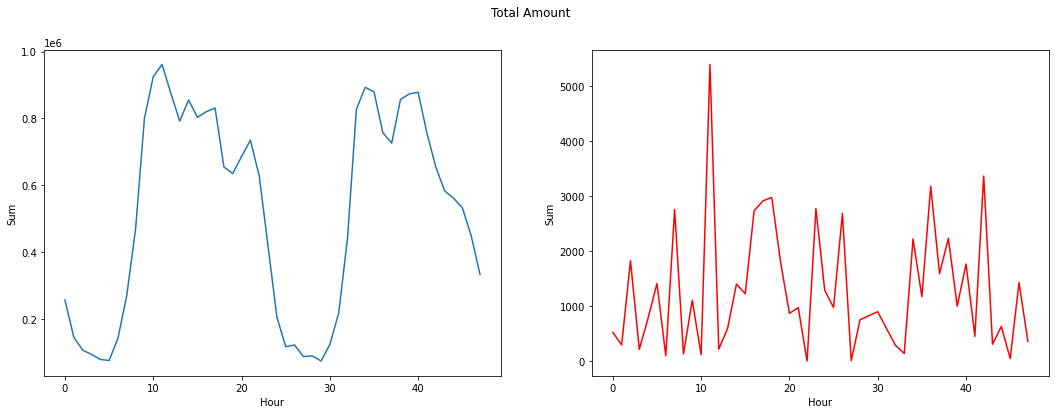

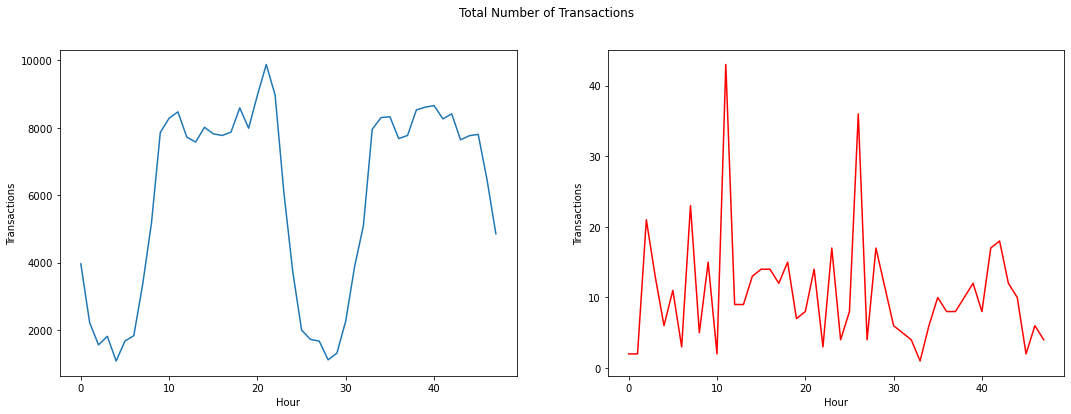

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

In [45]:
tmp = dataset[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
print('NON-FRAUD DETAILS')
print(class_0.describe())
print('\n\n')
print('FRAUD DETAILS')
print(class_1.describe())




NON-FRAUD DETAILS
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64



FRAUD DETAILS
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [3]:
#splitting the training and test data
from sklearn.model_selection import train_test_split

target = 'Class'
parameters = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

testsize = 0.2
train_data, test_data = train_test_split(dataset , test_size=testsize, random_state= 1879, shuffle=True )


In [14]:
#RandomForest Algorithm
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
RFC.fit(train_data[parameters] , train_data[target].values)

preds = RFC.predict(test_data[parameters])



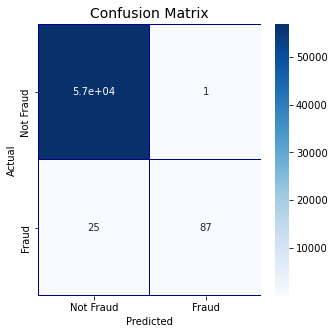

None


In [15]:
#confusion matrix for random forest classifier
cm = pd.crosstab(test_data[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
print(plt.show())



In [16]:
print("ROC AUC SCORE FOR RANDOM FORESTS IS : " , roc_auc_score(test_data[target].values, preds))

ROC AUC SCORE IS :  0.8883840620680991


In [5]:
#logistic Regression Algorithm
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(train_data[parameters] , train_data[target].values)

preds_logistic = classifier.predict(test_data[parameters])


[[56829    21]
 [   34    78]]


C:\Users\shrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



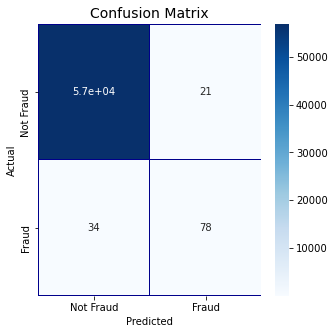

0.8480295891443649

In [8]:
#confusion matrix for logistic regression
cm = pd.crosstab(test_data[target].values, preds_logistic, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

print("ROC AUC SCORE FOR RANDOM FORESTS IS : " , roc_auc_score(test_data[target].values, preds_logistic))



In [10]:
#K-Nearest Neighbor Algorithm
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 15, metric = 'minkowski', p = 2)
classifier.fit(train_data[parameters] , train_data[target].values)


y_pred = classifier.predict(test_data[parameters])



KeyboardInterrupt: 

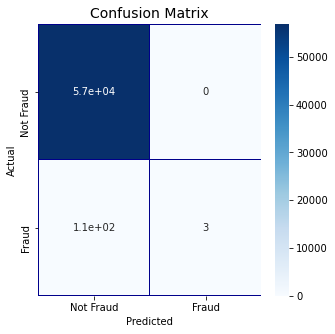

ROC AUC SCORE FOR RANDOM FORESTS IS :  0.5133928571428571


In [17]:

#confusion matrix for KNN
cm = pd.crosstab(test_data[target].values, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()


print("ROC AUC SCORE FOR RANDOM FORESTS IS : " , roc_auc_score(test_data[target].values, y_pred))
